In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from scipy.integrate import odeint, solve_ivp

from dataset import Dataset
import NeuralNet 

%load_ext autoreload
%autoreload 2

In [12]:
files = os.listdir('../Bioindustry/data/')
files = [f for f in files if f.startswith('BR')]
files.sort()

def get_data(files: list) -> pd.DataFrame:
    dfs = []
    for i, file in enumerate(files):
        df = pd.read_excel(f'../Bioindustry/data/{file}', header=0)
        df = df[1:]
        df['BR'] = i+1
        dfs.append(df)
    return pd.concat(dfs)

df = get_data(files)
df = df[df['Batch'] == 0]
df.to_csv('data_ceasar.csv')

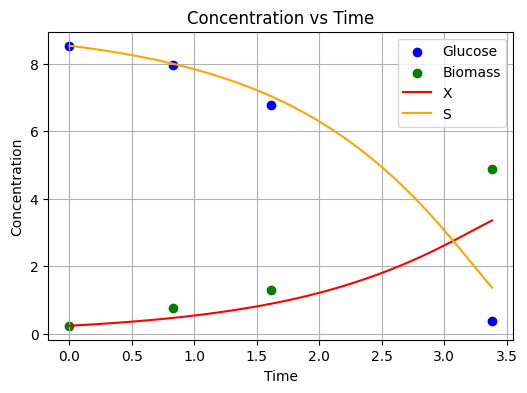

In [13]:
d = Dataset()
d.get_data(exp=2)

# Solve for 0.6794, 0.0002, 0.2572 kinetic parameter values
# mu_max_hat: 0.903, Km_hat: 0.826, Y_XS_hat: 0.435
sol = d.solve_ode(mu_max=0.903, Km=0.826, Y_XS=0.435)
d.plot_solution(sol)

# # Generate training data
# train_df = d.training_dataset(N=5000)
# print(f'Train data shape: {train_df.shape}')

## PINN

In [4]:
from PINN import PINN, get_loss

%load_ext autoreload
%autoreload 2

pinn = PINN(1, 2, T_START=d.df['Time'].min(), T_END=d.df['Time'].max())
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)
criterion = nn.MSELoss()

t_train = d.df['Time'].values
u_train = d.df[['Biomass', 'Glucose']].values

# Train data to tensor
ts_train = torch.tensor(t_train, requires_grad=True).float().view(-1,1)
us_train = torch.tensor(u_train, requires_grad=True).float()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
EPOCHS = 20000
LOSS = []
for epoch in range(EPOCHS):
    u_pred = pinn(ts_train)
    residual_pred = get_loss(pinn)
    loss = criterion(u_pred, us_train)
    loss += 0.5*residual_pred
    LOSS.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}, ODE Loss: {torch.mean(residual_pred).item()}')
        print(f'mu_max: {pinn.mu_max.item()}, Km: {pinn.Km.item()}, Y_XS: {pinn.Y_XS.item()}')

Epoch: 0, Loss: 20.91493034362793, ODE Loss: 0.0022074650041759014
mu_max: 0.4999000132083893, Km: 0.5001000165939331, Y_XS: 0.5001000165939331
Epoch: 500, Loss: 3.8664634227752686, ODE Loss: 0.44908562302589417
mu_max: 0.4327036440372467, Km: 0.5545117259025574, Y_XS: 0.5648730397224426
Epoch: 1000, Loss: 0.9711297154426575, ODE Loss: 0.377773642539978
mu_max: 0.4240244925022125, Km: 0.569195568561554, Y_XS: 0.5653791427612305
Epoch: 1500, Loss: 0.6344583034515381, ODE Loss: 0.3328035771846771
mu_max: 0.4768936038017273, Km: 0.5518880486488342, Y_XS: 0.5001823306083679
Epoch: 2000, Loss: 0.458412766456604, ODE Loss: 0.23205196857452393
mu_max: 0.5167213678359985, Km: 0.56165611743927, Y_XS: 0.4479253590106964
Epoch: 2500, Loss: 0.3361396789550781, ODE Loss: 0.15768632292747498
mu_max: 0.5464474558830261, Km: 0.6061106324195862, Y_XS: 0.4083614945411682
Epoch: 3000, Loss: 0.2452109307050705, ODE Loss: 0.10289528220891953
mu_max: 0.5723406672477722, Km: 0.6585571765899658, Y_XS: 0.37862

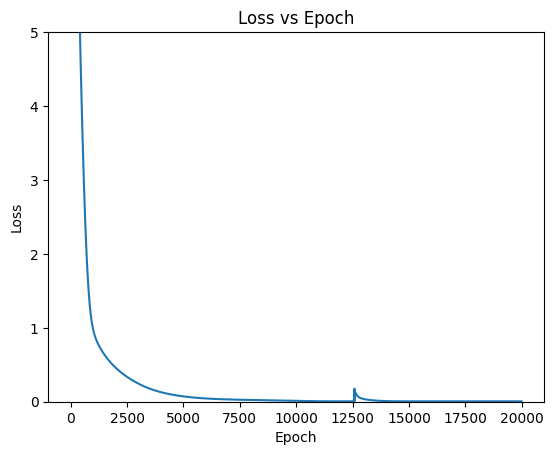

In [9]:
plt.plot(LOSS, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 5)
plt.title('Loss vs Epoch')
plt.show()

In [10]:
print(f'mu_max: {pinn.mu_max.item()}, Km: {pinn.Km.item()}, Y_XS: {pinn.Y_XS.item()}')

mu_max: 0.8029115796089172, Km: 0.0002884756540879607, Y_XS: 0.44583457708358765


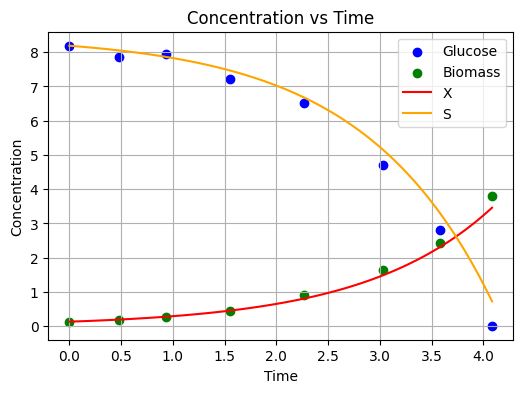

In [11]:
sol_pinn = d.solve_ode(mu_max=pinn.mu_max.item(), Km=pinn.Km.item(), Y_XS=pinn.Y_XS.item())
d.plot_solution(sol_pinn)